In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, MaxPool1D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import time

import pickle
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
TEST_PROPORTION = 0.3
N_BACS = 16
N_FEATURES = 241
DATASTORE = '/content/drive/MyDrive/preprocess_bac/'
PICKLES_PATH = os.path.join(DATASTORE, 'pickles')
LABELS = []
def load_img_data(ammount):
    bacs = []
    dirs = os.listdir(DATASTORE)
    count = 0
    for i in dirs:
      if count < ammount:
        count += 1
        LABELS.append(i)
        dirpath = os.path.join(DATASTORE, i)
        files = os.listdir(dirpath)
        for j in files:
          if j == 'masked.pickle':
            pickle_in = open(os.path.join(dirpath, j), "rb")
            bacs.append(pickle.load(pickle_in))
    return bacs

def get_layer(hsi, layer):
    return hsi[:, :, layer]

def show_img_on_wave(cube, layer):
    mat = get_layer(cube, layer)
    plt.imshow(mat, cmap='gray')
    plt.show()


def hsi2mat(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))


def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def remove_blank_lines(bacs):
    new_bacs = []
    for i in bacs:
        bac = hsi2mat(i)
        new_bac = bac[~np.all(bac == 0, axis=1)]
        new_bacs.append(new_bac)
    return new_bacs

def create_training_dataset(bacs):
    trainingset = []
    for ind, val in enumerate(bacs):
        trainingset.append([val, ind])
    return trainingset

def concat_lines_on_datasets(xtrain, ytrain, xtest, ytest, bac, cl: int):
    pp = int(bac.shape[0]*TEST_PROPORTION)
    vtest = bac[:pp, :]
    if (xtest.shape[0] > 0):
      xtest = np.concatenate((xtest, vtest))
    else:
      xtest = vtest
    ytest = np.append(ytest, [cl]*vtest.shape[0])

    vtrain = bac[pp:, :]
    if (xtrain.shape[0] > 0):
      xtrain = np.concatenate((xtrain, vtrain))
    else:
      xtrain = vtrain

    ytrain = np.append(ytrain, [cl]*vtrain.shape[0])
    return (xtrain, ytrain, xtest, ytest)

def create_one_hot_encoding(dataset, features):
  y = np.zeros((dataset.shape[0], features))
  for i in range(len(dataset)):
    y[i,int(dataset[i])] = 1
  return y

def split_train_test(dataset):
    xtrain = np.array([])
    ytrain = np.array([])
    xtest = np.array([])
    ytest = np.array([])
    for f, l in dataset:
        xtrain, ytrain, xtest, ytest = concat_lines_on_datasets(xtrain, ytrain, xtest, ytest, f, l)

    yy = create_one_hot_encoding(ytrain, N_BACS)
    seed = np.random.randint(0, 1000*1000)
    np.random.seed(seed)
    np.random.shuffle(xtrain)
    np.random.seed(seed)
    np.random.shuffle(yy)
    return (xtrain, yy, xtest, create_one_hot_encoding(ytest, N_BACS))

def load_dataset(ammount=0):
    bacs = load_img_data(ammount)
    nozeros = remove_blank_lines(bacs)
    return create_training_dataset(nozeros)


def normalize(data):
    return tf.keras.utils.normalize(data, 1)

def save_pickle(data, name):
    pickle_out = open(os.path.join(PICKLES_PATH, name), "wb")
    pickle.dump(data, pickle_out)

    pickle_out.close()
    
def load_pickle(filename):
    picklein = open(os.path.join(PICKLES_PATH, filename), "rb")
    return pickle.load(picklein)

In [ ]:
# JA TA SALVO
# bacs = load_dataset(N_BACS)
# xtrain, ytrain, xtest, ytest = split_train_test(bacs)
# norm_xtrain = normalize(xtrain)
# NORM_XTRAIN = norm_xtrain.reshape((norm_xtrain.shape[0], norm_xtrain.shape[1], 1))
# norm_xtest = normalize(xtest)
# NORM_XTEST = norm_xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [ ]:
# save_pickle(NORM_XTRAIN, 'xtrain.pickle')
# save_pickle(ytrain, 'ytrain.pickle')
# save_pickle(NORM_XTEST, 'xtest.pickle')
# save_pickle(ytest, 'ytest.pickle')

In [ ]:
xtrain = load_pickle('xtrain.pickle')
ytrain = load_pickle('ytrain.pickle')
xtest = load_pickle('xtest.pickle')
ytest = load_pickle('ytest.pickle')

In [ ]:
model = Sequential([
                    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(N_FEATURES,1)),
                    MaxPool1D(pool_size=2),
                    Conv1D(filters=64, kernel_size=2, activation='relu'),
                    MaxPool1D(pool_size=2),
                    Flatten(),
                    Dense(N_BACS, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 239, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 119, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 118, 64)           16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3776)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                60432     
Total params: 77,392
Trainable params: 77,392
Non-trainable params: 0
____________________________________________________

In [ ]:
model.fit(NORM_XTRAIN, ytrain, epochs=15, batch_size=32, validation_split=0.3 ,verbose=1)

Epoch 1/15
11111/11111 [==============================] - 105s 7ms/step - loss: 0.5964 - accuracy: 0.8514 - val_loss: 0.3222 - val_accuracy: 0.9187
Epoch 2/15
11111/11111 [==============================] - 75s 7ms/step - loss: 0.3127 - accuracy: 0.9207 - val_loss: 0.2858 - val_accuracy: 0.9264
Epoch 3/15
11111/11111 [==============================] - 88s 8ms/step - loss: 0.2707 - accuracy: 0.9282 - val_loss: 0.2761 - val_accuracy: 0.9262
Epoch 4/15
11111/11111 [==============================] - 82s 7ms/step - loss: 0.2450 - accuracy: 0.9338 - val_loss: 0.2489 - val_accuracy: 0.9325
Epoch 5/15
11111/11111 [==============================] - 82s 7ms/step - loss: 0.2247 - accuracy: 0.9387 - val_loss: 0.2060 - val_accuracy: 0.9448
Epoch 6/15
11111/11111 [==============================] - 82s 7ms/step - loss: 0.2101 - accuracy: 0.9419 - val_loss: 0.1916 - val_accuracy: 0.9468
Epoch 7/15
11111/11111 [==============================] - 87s 8ms/step - loss: 0.1997 - accuracy: 0.9444 - val_loss: 

In [ ]:
model.evaluate(NORM_XTEST, ytest, batch_size=32)

6803/6803 [==============================] - 27s 4ms/step - loss: 0.5086 - accuracy: 0.8811


[0.5086489915847778, 0.8811008930206299]

In [ ]:
ypred = model.predict(NORM_XTEST, batch_size=32, verbose=1)

6803/6803 [==============================] - 11s 2ms/step


In [ ]:
labels = tf.argmax(ytest, axis=1)
predict = tf.argmax(ypred, axis=1)

# conf_mat = tf.math.confusion_matrix(labels, predict, N_BACS)

# print(conf_mat)
cm = confusion_matrix(labels, predict)

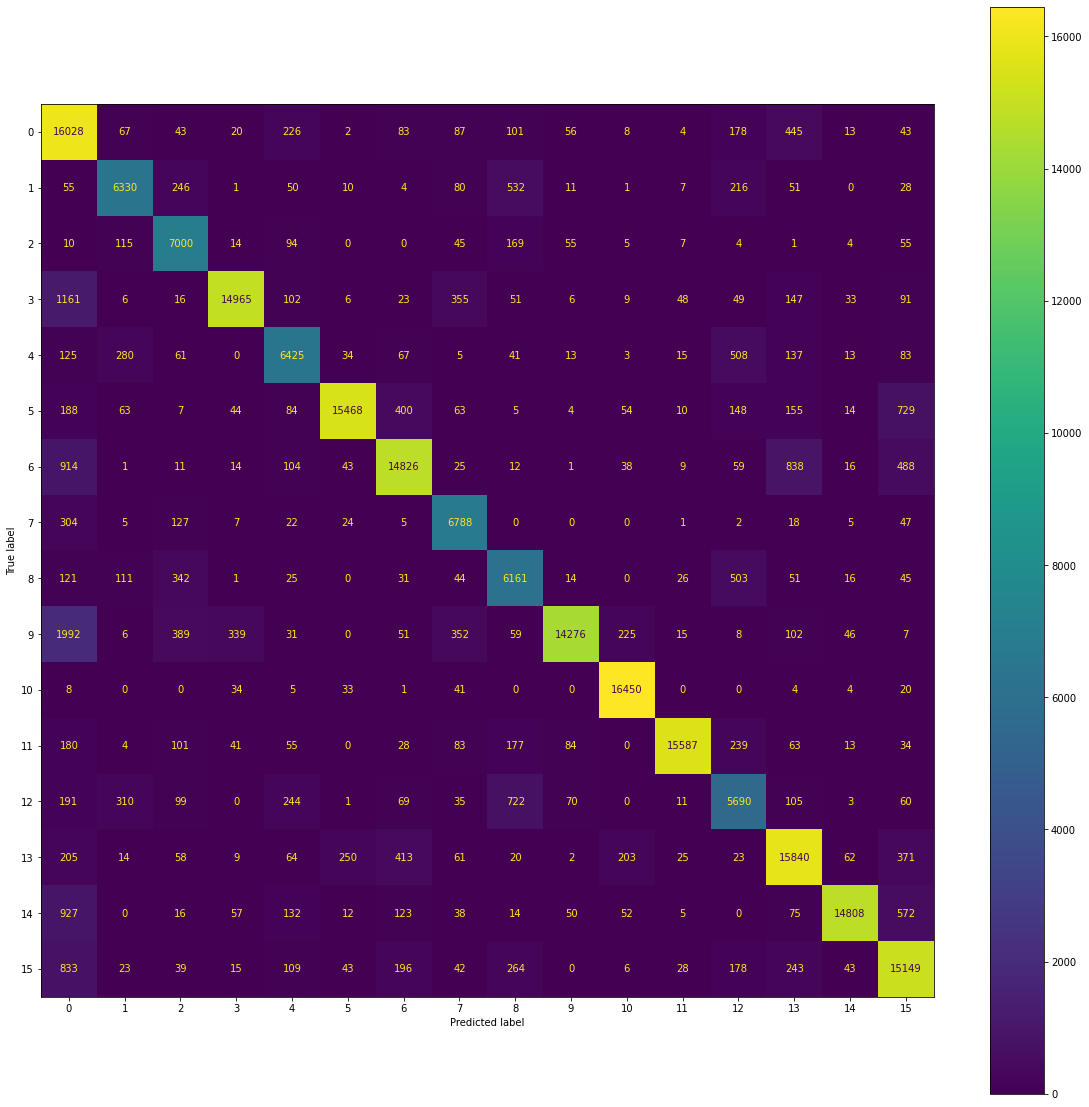

In [ ]:
cmp = ConfusionMatrixDisplay(cm, np.arange(16))
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax, values_format='d')

In [ ]:
classfic = classification_report(labels, predict, np.arange(16), LABELS)
print(classfic)

                                                                 precision    recall  f1-score   support

               Serratiamarcences_14765_Plastico_B_180926-105123       0.69      0.92      0.79     17404
Staphylococcusaureus_25923_Plastico_A_Contaminado_180926-101609       0.86      0.83      0.85      7622
        Staphylococcusepidemides_12228_Plastico_A_180926-094711       0.82      0.92      0.87      7578
          Pseudomonasaeoruginosas_9027_Plastico_B_180926-104046       0.96      0.88      0.92     17068
                 Proteusmirabilis_9433_Plastico_A_180926-103212       0.83      0.82      0.82      7810
            Klebsielapneumonial_700603_Plastico_B_180926-105913       0.97      0.89      0.93     17436
                   Salmonellaspp_10708_Plastico_B_180926-104803       0.91      0.85      0.88     17399
                 Escherichiacoli_25922_Plastico_A_180926-101939       0.83      0.92      0.88      7355
             Staphylococcusaureus_6538_Plastico_A_1809

In [ ]:
mlp_model = Sequential([
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(N_BACS, activation='softmax')
])

mlp_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
mlp_model.fit(NORM_XTRAIN, ytrain, epochs=15, batch_size=32, validation_split=0.3 ,verbose=1)

Epoch 1/15
11111/11111 [==============================] - 25s 2ms/step - loss: 1.0414 - accuracy: 0.7180 - val_loss: 0.5813 - val_accuracy: 0.8423
Epoch 2/15
11111/11111 [==============================] - 26s 2ms/step - loss: 0.4497 - accuracy: 0.8793 - val_loss: 0.3722 - val_accuracy: 0.8932
Epoch 3/15
11111/11111 [==============================] - 25s 2ms/step - loss: 0.3385 - accuracy: 0.9014 - val_loss: 0.3172 - val_accuracy: 0.9040
Epoch 4/15
11111/11111 [==============================] - 26s 2ms/step - loss: 0.2953 - accuracy: 0.9111 - val_loss: 0.2676 - val_accuracy: 0.9206
Epoch 5/15
11111/11111 [==============================] - 26s 2ms/step - loss: 0.2639 - accuracy: 0.9190 - val_loss: 0.2437 - val_accuracy: 0.9256
Epoch 6/15
11111/11111 [==============================] - 25s 2ms/step - loss: 0.2432 - accuracy: 0.9240 - val_loss: 0.2306 - val_accuracy: 0.9263
Epoch 7/15
11111/11111 [==============================] - 26s 2ms/step - loss: 0.2286 - accuracy: 0.9280 - val_loss: 0

In [ ]:
mlp_model.evaluate(NORM_XTEST, ytest, batch_size=32)

6803/6803 [==============================] - 8s 1ms/step - loss: 0.4634 - accuracy: 0.8691


[0.46344223618507385, 0.8691058158874512]